Regrid each files -> average -> plot

In [1]:
import xesmf as xe
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os

In [2]:
files = sorted(glob.glob(
    "/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.202308*.nc"
))
print(files)


['/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.2023080100.5deg.ll.nc', '/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.2023080106.5deg.ll.nc', '/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.2023080112.5deg.ll.nc', '/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.2023080118.5deg.ll.nc', '/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3.thin.25km.and.TROPOMICO.VIIRSAOD.FRAC.em12.phys.1.e-12.phys2/C192/5DEGll/tracer.2023080200.5deg.ll.nc', '/ships22/raqms/lenzen/FV3GFS.9.1.2023/O3.OMPSLPMLSbias.OMPS.NM.CLDFR3.SZA70.O3

In [3]:
raqms_ds = xr.open_dataset(files[0])
print(raqms_ds)
print(raqms_ds.dims)
print(raqms_ds.coords)


<xarray.Dataset> Size: 8GB
Dimensions:      (time: 1, tile: 6, grid_xt: 720, grid_yt: 361, grid_zt: 64)
Coordinates:
  * time         (time) float64 8B 213.0
  * grid_xt      (grid_xt) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * grid_yt      (grid_yt) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * grid_zt      (grid_zt) float64 512B 1.0 2.0 3.0 4.0 ... 61.0 62.0 63.0 64.0
Dimensions without coordinates: tile
Data variables: (12/175)
    imin         (tile) int32 24B ...
    imax         (tile) int32 24B ...
    jmin         (tile) int32 24B ...
    jmax         (tile) int32 24B ...
    lat          (time, grid_yt, grid_xt) float32 1MB ...
    lon          (time, grid_yt, grid_xt) float32 1MB ...
    ...           ...
    jo1d         (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    jno          (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    cot6hr       (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    emcofire     (time, grid_zt, grid_yt, grid_xt) fl

In [4]:
raqms_lat = raqms_ds['lat'].isel(time=0)
raqms_lon = raqms_ds['lon'].isel(time=0)

In [5]:
gems_file = '/ships22/raqms/Satellite/GEMS/L3/NO2/GK2_GEMS_L3_20230802_NO2_GRID-EA_daily_010.nc'
gems_ds = xr.open_dataset(gems_file, group='Geolocation Fields')

gems_lat = gems_ds['Latitude']
gems_lon = gems_ds['Longitude']


In [6]:
source_grid = {'lat': raqms_lat, 'lon': raqms_lon}
target_grid = {'lat': gems_lat, 'lon': gems_lon}

In [7]:
regridder = xe.Regridder(source_grid, target_grid, method='bilinear', periodic=True)


In [8]:
output_dir = "RAQMS_Regridded_nomask"
os.makedirs(output_dir, exist_ok=True)

#regrid all files
for file_path in files:
    ds = xr.open_dataset(file_path)
    no2 = ds['no2tot'].isel(time=0) * 100  # Convert from 1e18 to 1e16 molecules/cm²

    # Regrid
    no2_regridded = regridder(no2)

    # Save regridded nc files
    base = os.path.basename(file_path)
    out_path = os.path.join(output_dir, base)
    out_ds = xr.Dataset({'no2tot': no2_regridded})
    out_ds.to_netcdf(out_path)
    print(f"Saved regridded file: {out_path}")



Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080100.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080106.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080112.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080118.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080200.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080206.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080212.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080218.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080300.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080306.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080312.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080318.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_nomask/tracer.2023080400.5deg.ll.nc
Saved regridded file: RAQMS_Regridded_

In [9]:
n_files = sorted(glob.glob("/home/alubianashari/RAQMS_Regridded_nomask/tracer.202308*.nc"))
print(n_files)

['/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080100.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080106.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080112.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080118.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080200.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080206.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080212.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080218.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080300.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080306.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080312.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080318.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded_nomask/tracer.2023080400.5deg.ll.nc', '/home/alubianashari/RAQ

In [10]:
#grouping files by day
daily_files = {}
for f in n_files:
    filename = os.path.basename(f)
    timestamp = filename.split('.')[1]
    date_str = timestamp[:8]

    if date_str not in daily_files:
        daily_files[date_str] = [f]
    else:
        daily_files[date_str].append(f)
print(daily_files.keys())

dict_keys(['20230801', '20230802', '20230803', '20230804', '20230805', '20230806', '20230807', '20230808', '20230809', '20230810', '20230811', '20230812', '20230813', '20230814', '20230815', '20230816', '20230817', '20230818', '20230819', '20230820', '20230821', '20230822', '20230823', '20230824', '20230825', '20230826', '20230827', '20230828', '20230829', '20230830', '20230831'])


In [4]:
day_files = daily_files['20230802']
print(day_files)

['/home/alubianashari/RAQMS_Regridded/tracer.2023080200.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded/tracer.2023080206.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded/tracer.2023080212.5deg.ll.nc', '/home/alubianashari/RAQMS_Regridded/tracer.2023080218.5deg.ll.nc']


20230801


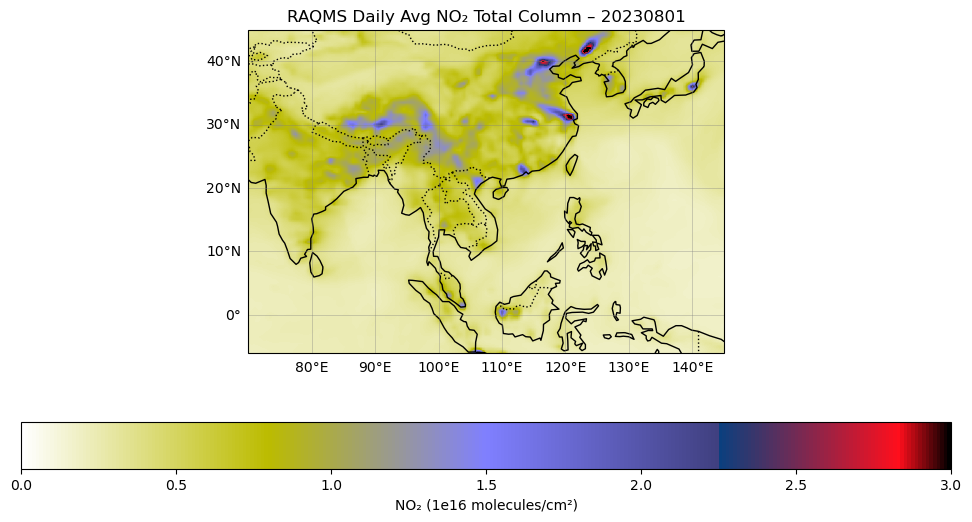

20230802


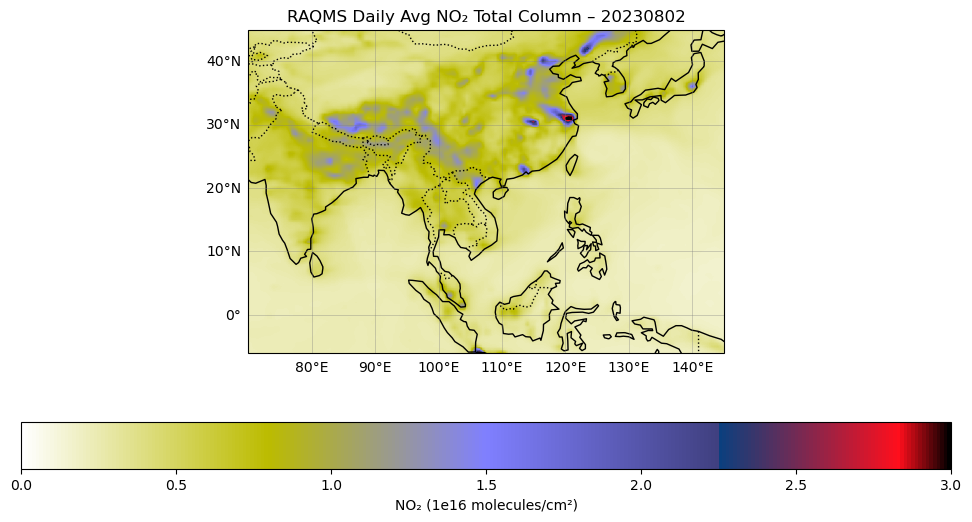

20230803


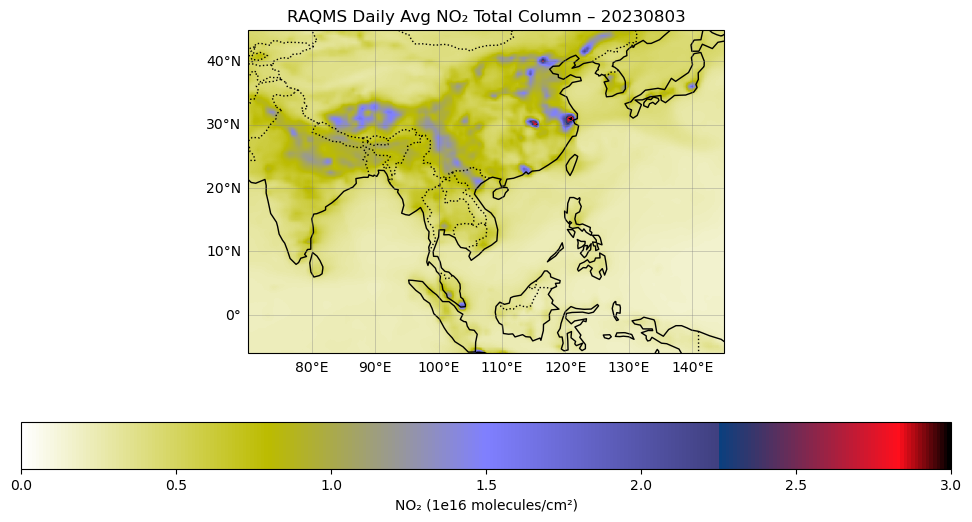

20230804


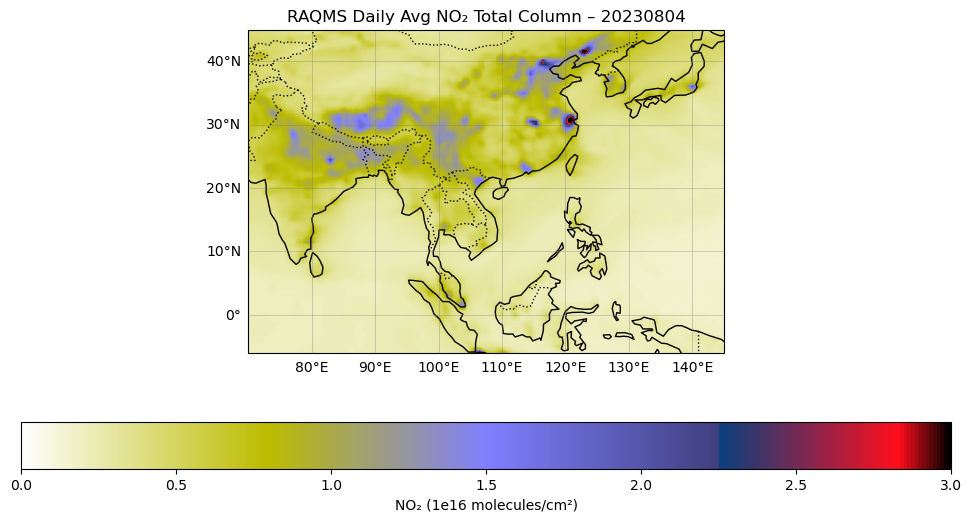

20230805


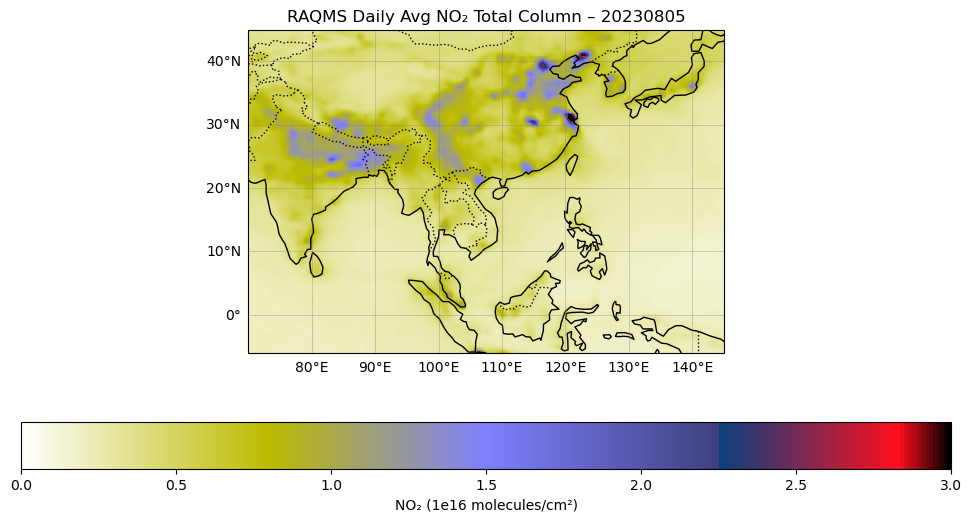

20230806


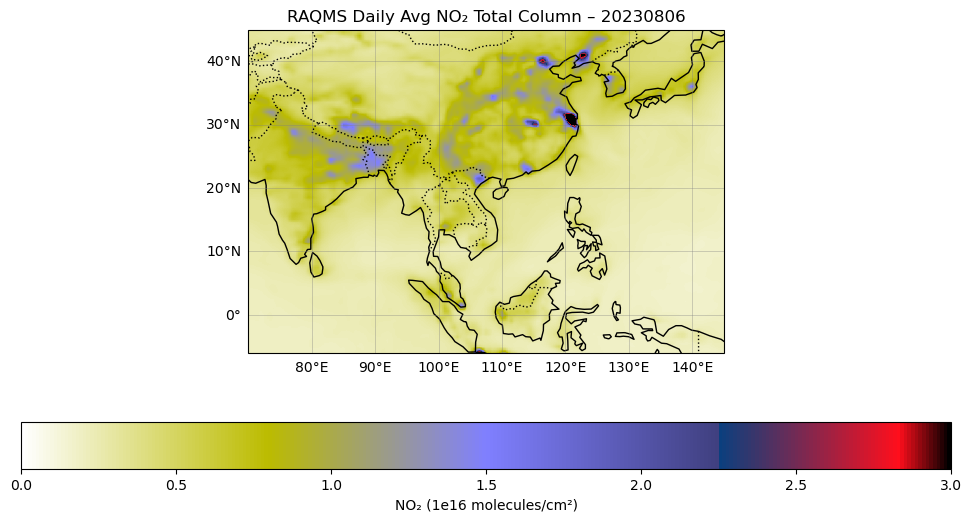

20230807


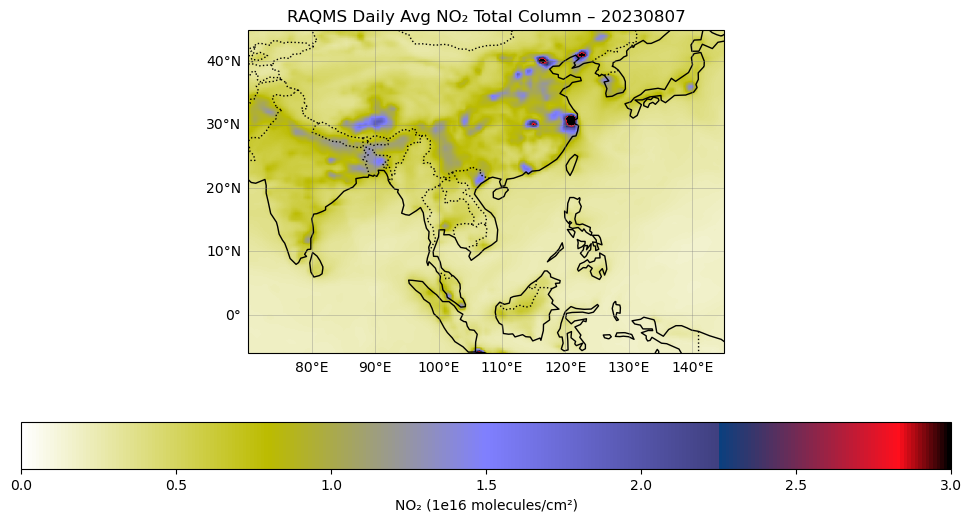

20230808


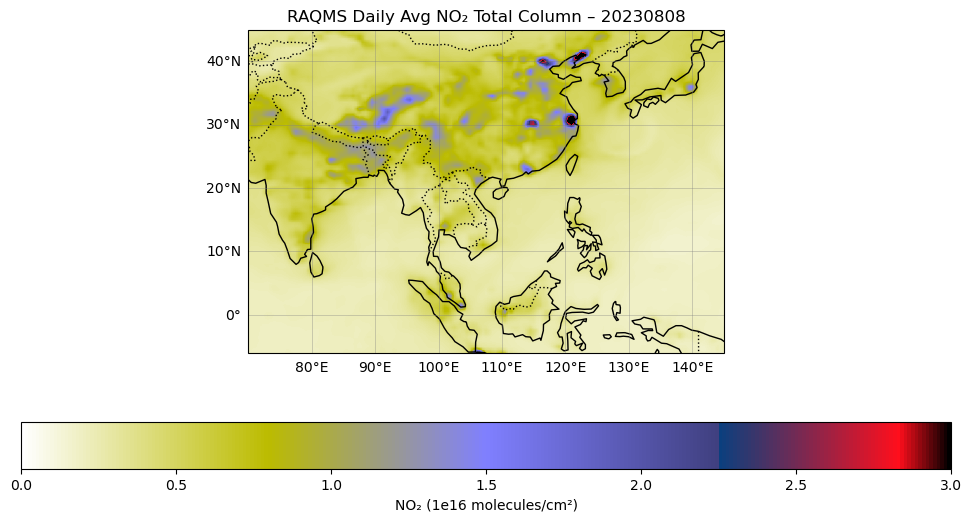

20230809


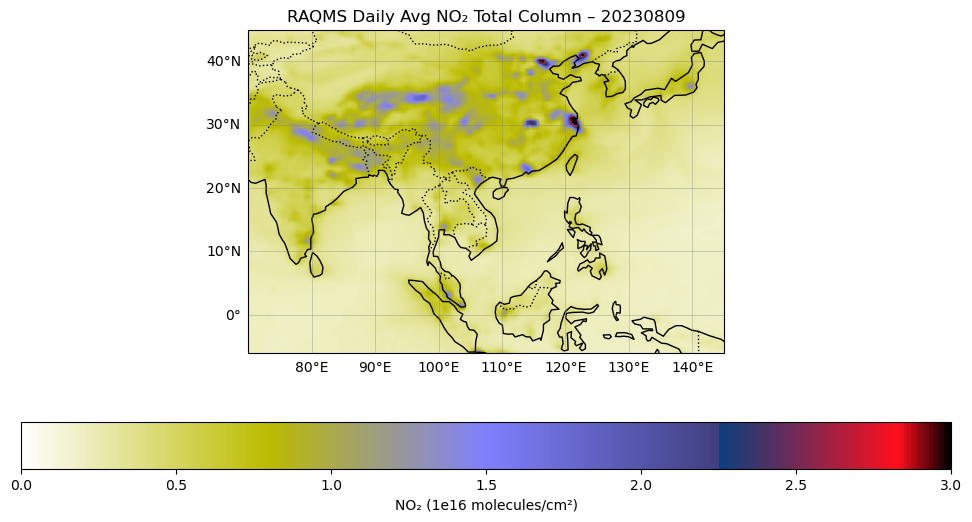

20230810


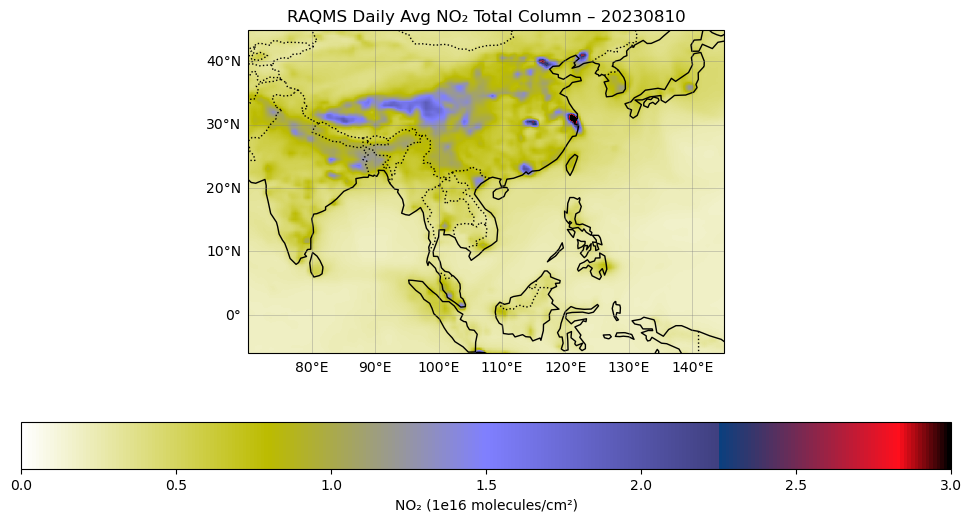

20230811


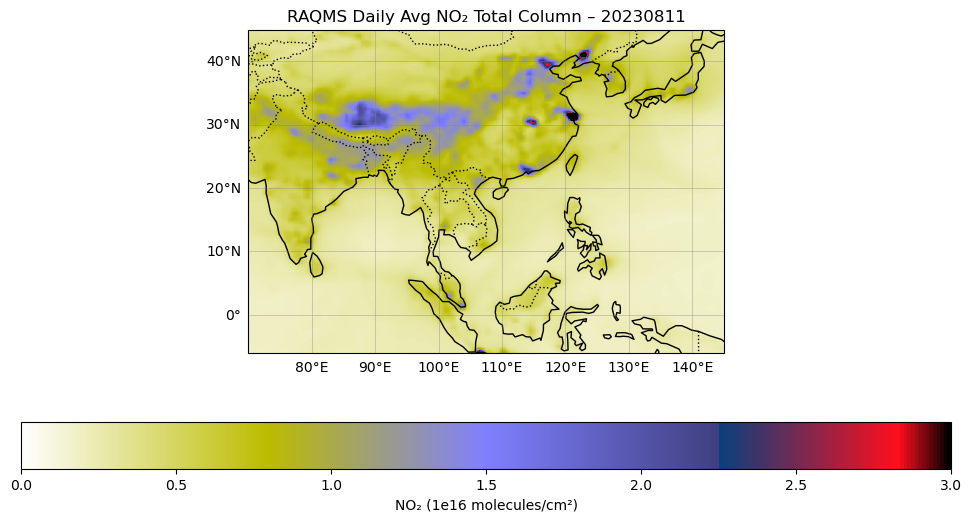

20230812


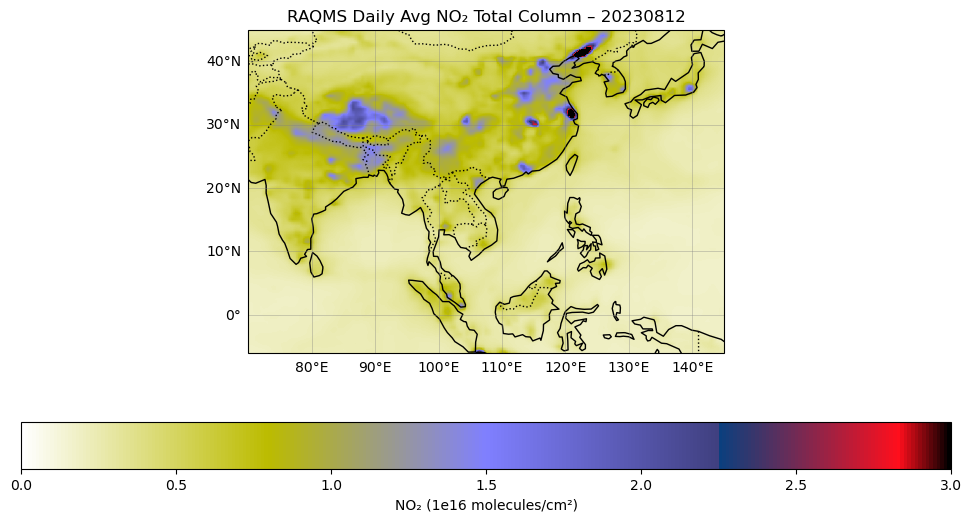

20230813


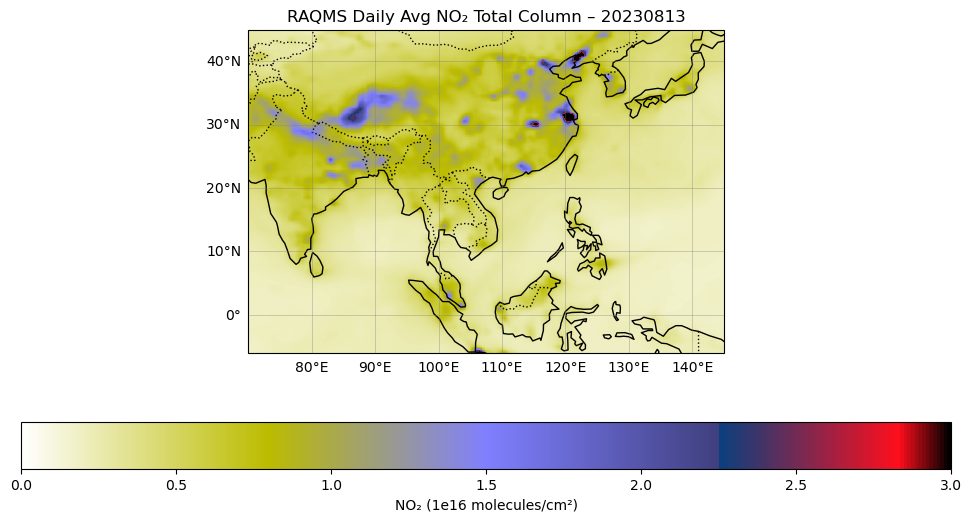

20230814


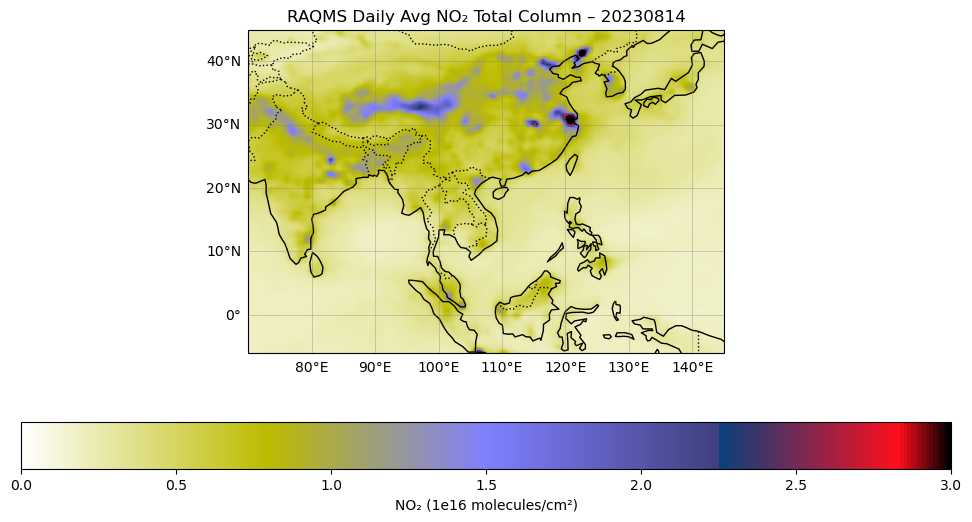

20230815


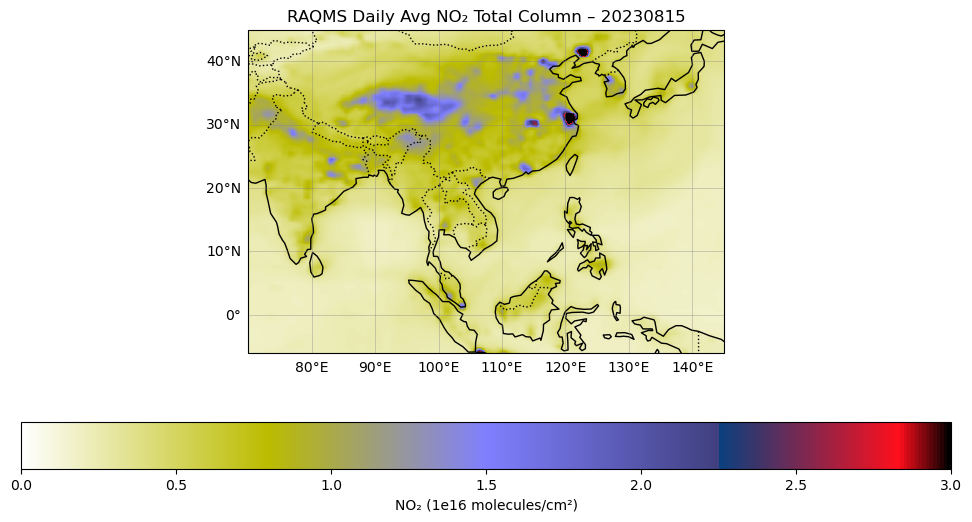

20230816


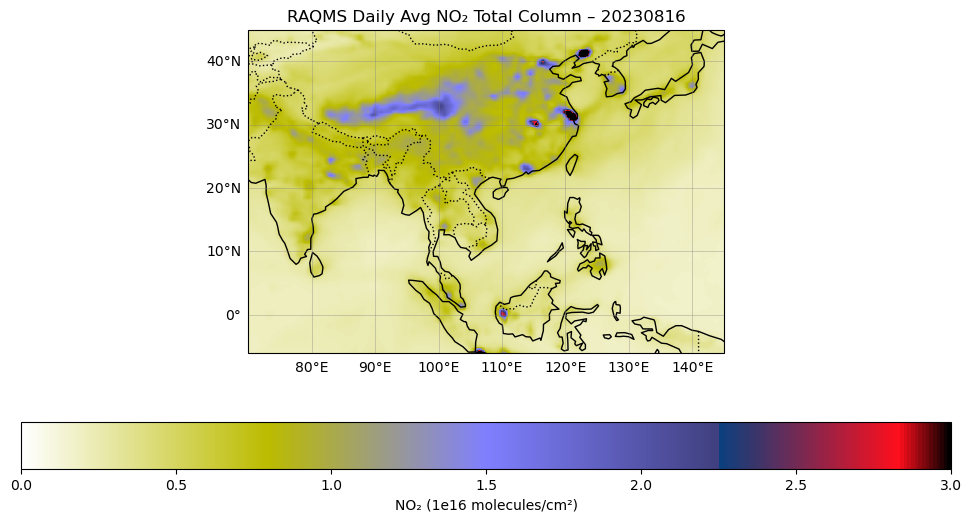

20230817


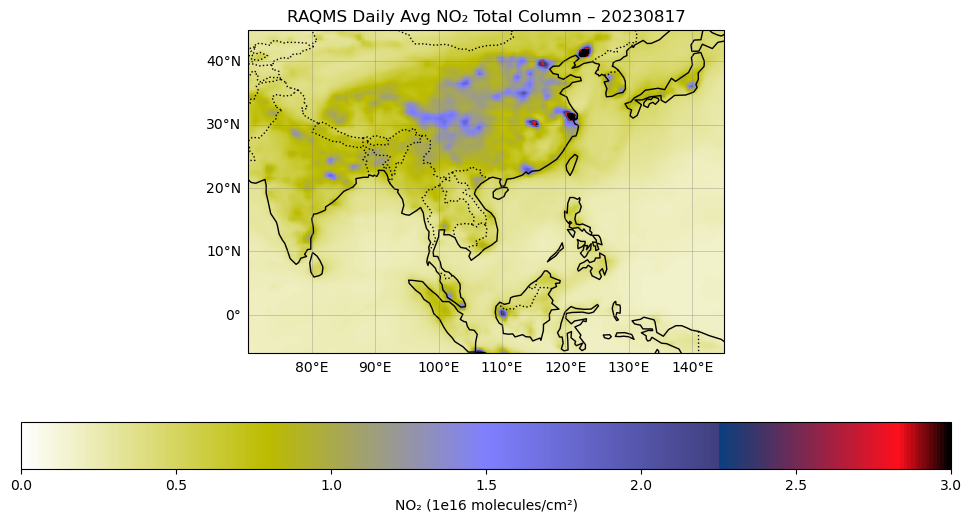

20230818


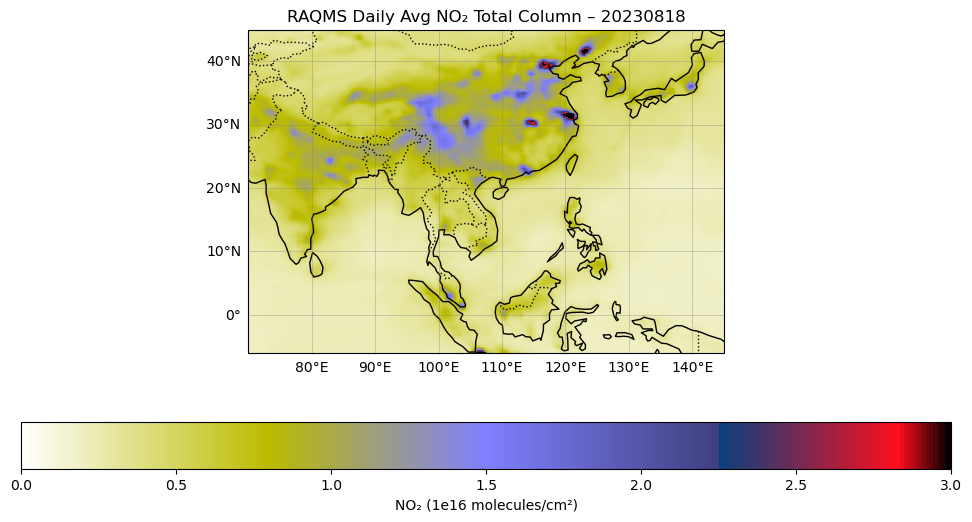

20230819


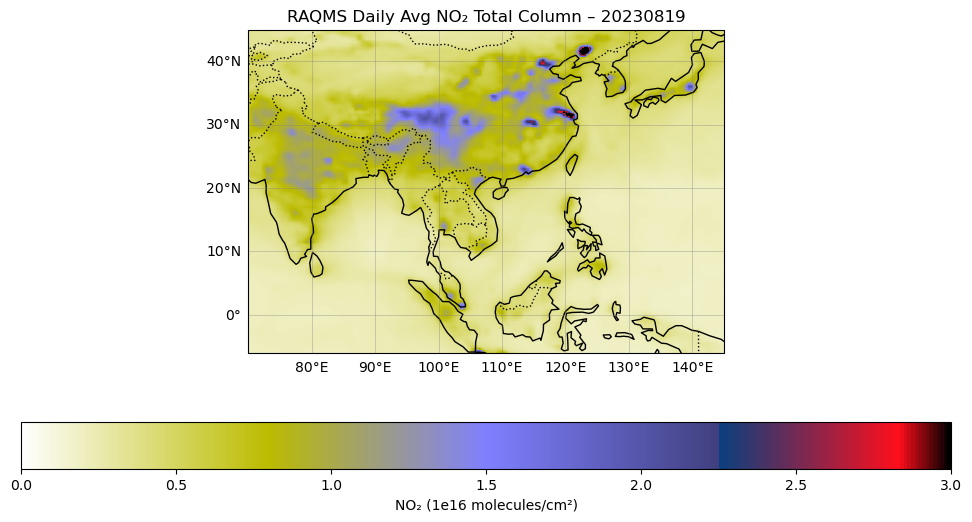

20230820


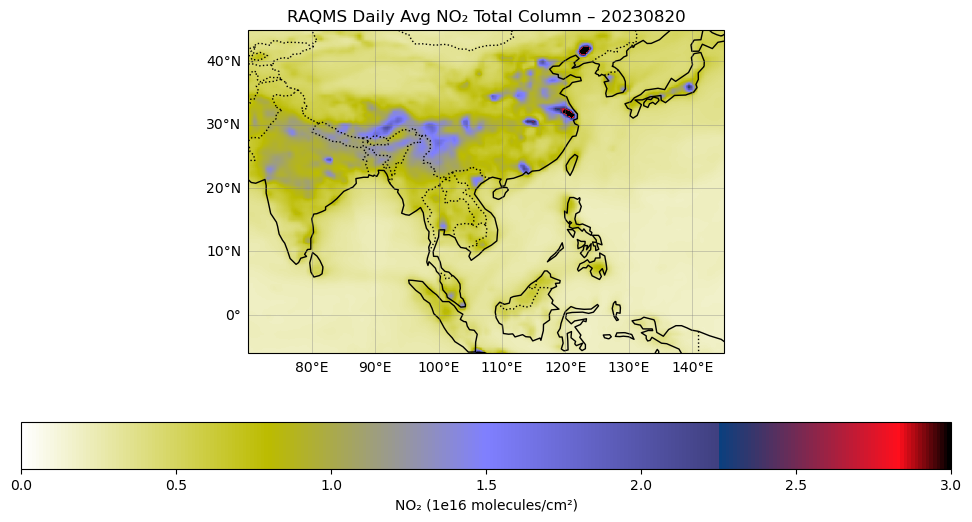

20230821


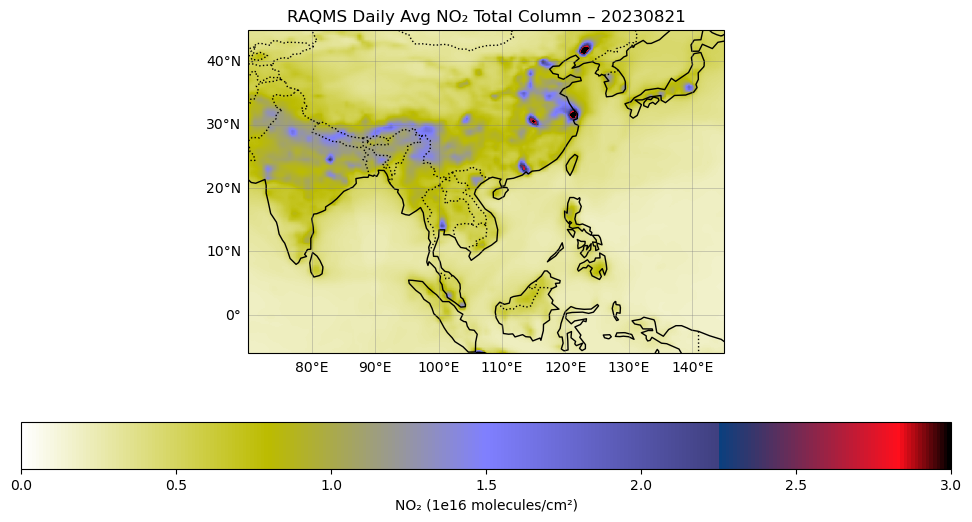

20230822


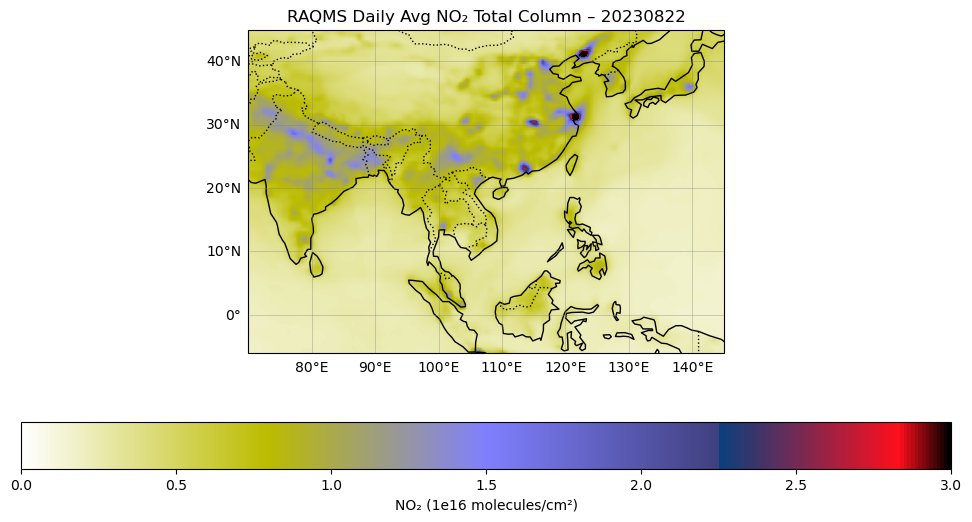

20230823


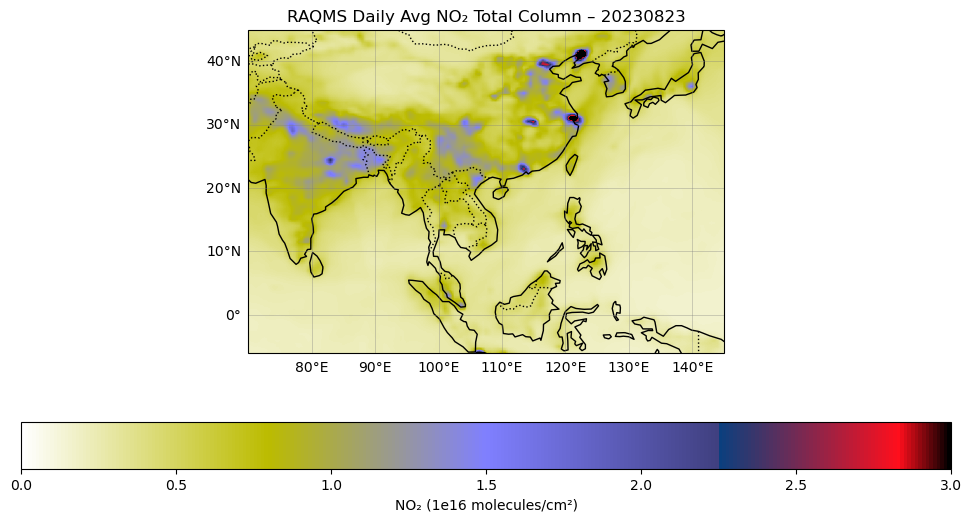

20230824


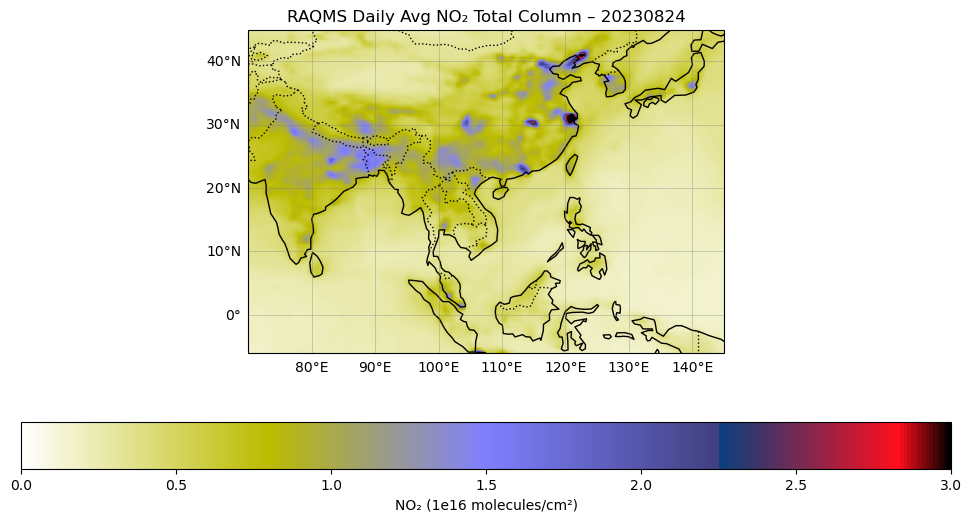

20230825


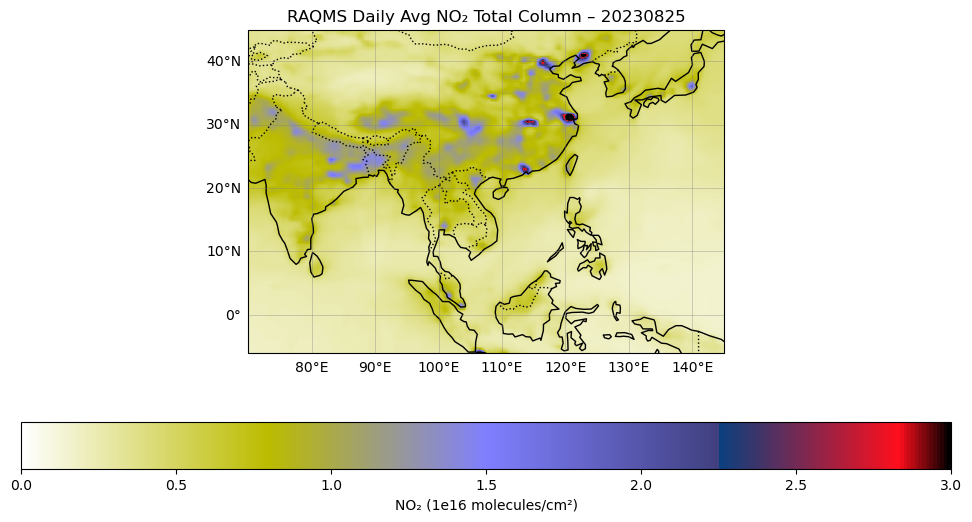

20230826


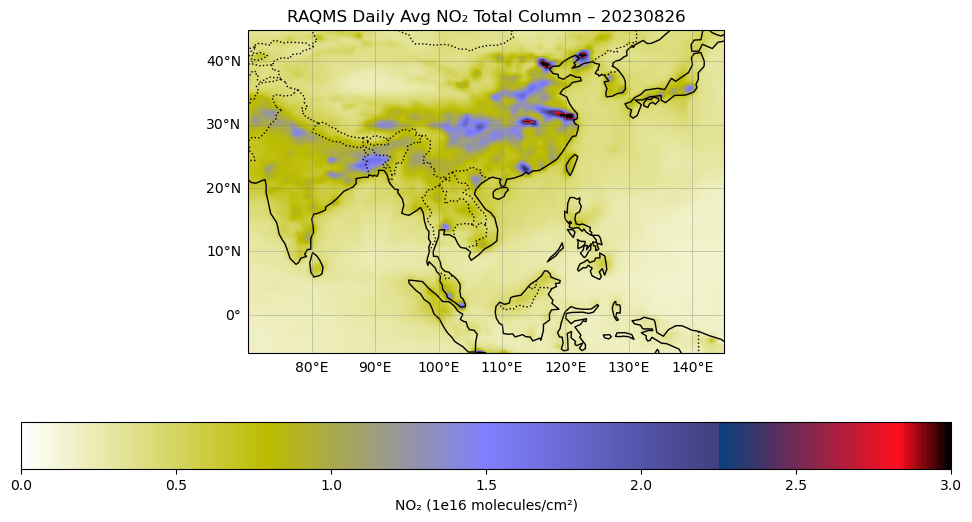

20230827


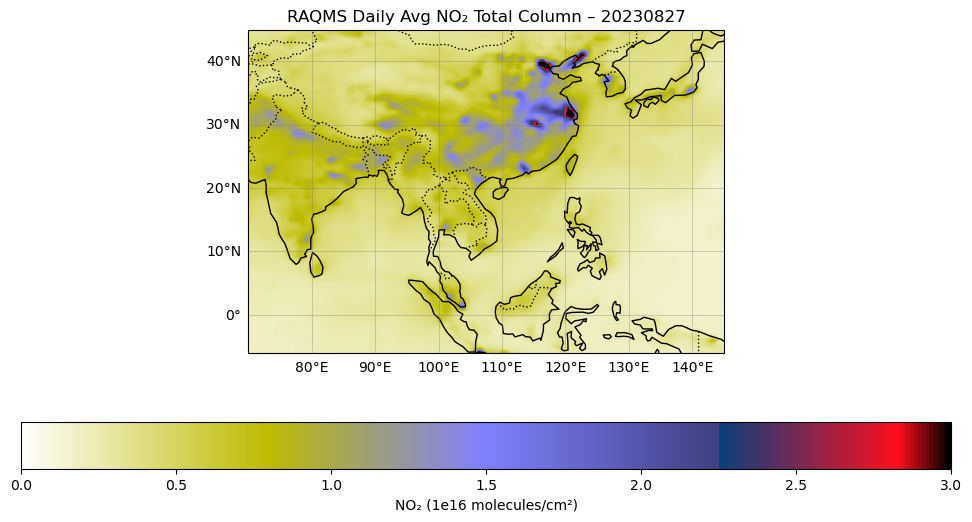

20230828


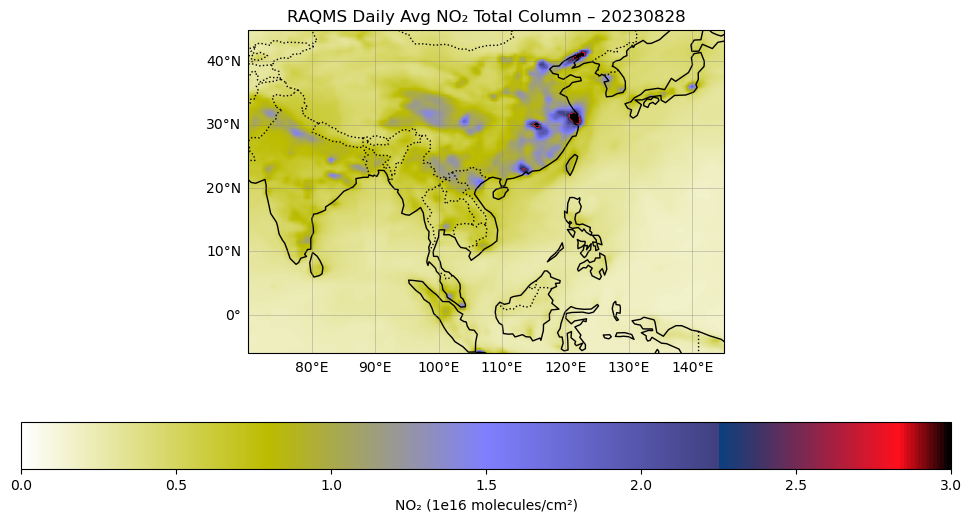

20230829


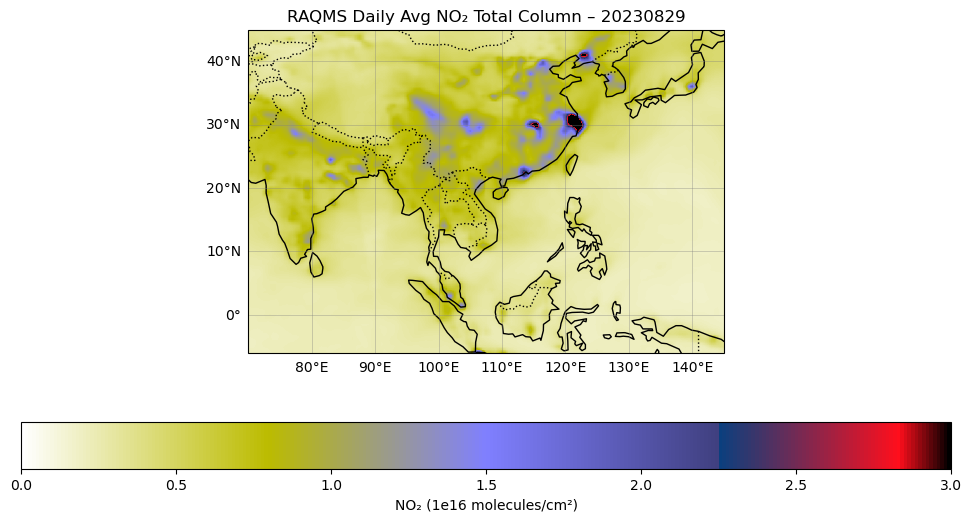

20230830


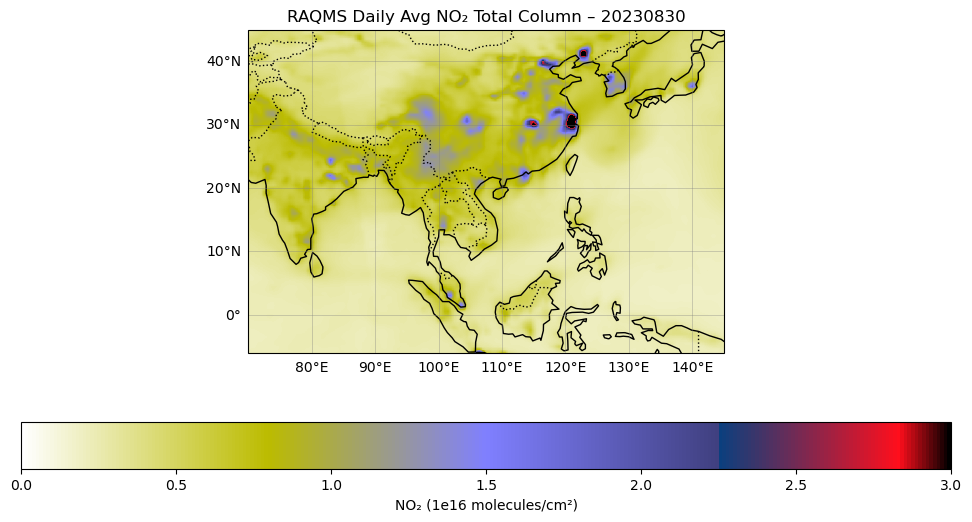

20230831


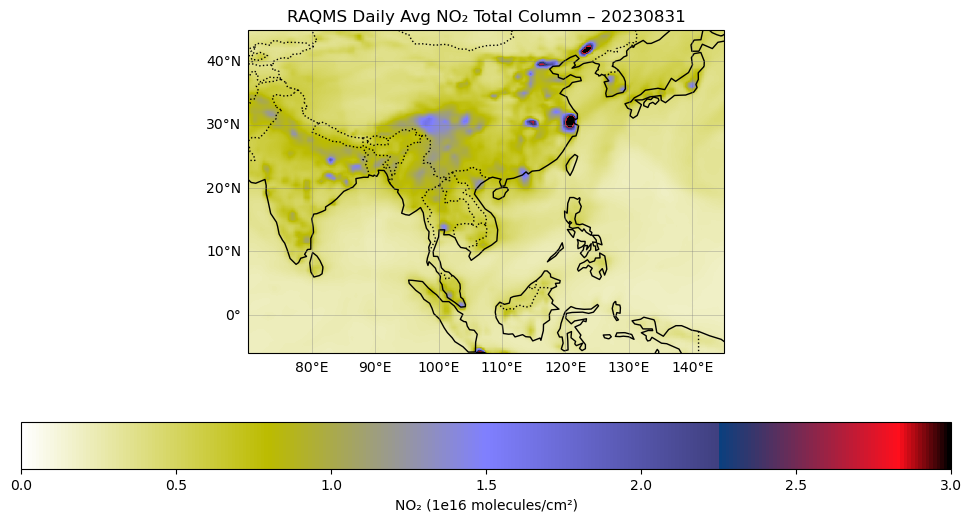

In [14]:
os.makedirs("Figures_nomask", exist_ok=True)
# Plotting NO2 for a specific day
# Loop through the dates and plot the NO2 data
dates = [
    '20230801', '20230802', '20230803', '20230804', '20230805',
    '20230806', '20230807', '20230808', '20230809', '20230810',
    '20230811', '20230812', '20230813', '20230814', '20230815',
    '20230816', '20230817', '20230818', '20230819', '20230820',
    '20230821', '20230822', '20230823', '20230824', '20230825',
    '20230826', '20230827', '20230828', '20230829', '20230830',
    '20230831'
]

for i in range(0, len(dates)):
    date = str(dates[i])
    print(date)
    day_files = daily_files[date]

    datasets = xr.open_dataset(day_files[0])
    lat = datasets['Latitude']
    lon = datasets['Longitude']
    ds_NO2_00 = np.array(datasets['no2tot'])
    datasets = xr.open_dataset(day_files[1])
    ds_NO2_06 = np.array(datasets['no2tot'])
    datasets = xr.open_dataset(day_files[2])
    ds_NO2_12 = np.array(datasets['no2tot'])
    datasets = xr.open_dataset(day_files[3])
    ds_NO2_18 = np.array(datasets['no2tot'])

    # Stack the NO2 data for the four time points
    ds_NO2 = np.stack([ds_NO2_00, ds_NO2_06, ds_NO2_12, ds_NO2_18], axis=0)
    no2_daily_avg = ds_NO2.mean(axis=0)  # shape: (540, 750)

    # Plotting
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon, lat, no2_daily_avg,
        transform=ccrs.PlateCarree(),
        cmap='gist_stern_r',
        vmin=0,
        vmax=3
    )

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xlim(70, 145)
    ax.set_ylim(-6, 45)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(f'RAQMS Daily Avg NO₂ Total Column – {date}')
    plt.colorbar(mesh, orientation='horizontal', label='NO₂ (1e16 molecules/cm²)')
    plt.savefig(f"Figures_nomask/{date}.png")
    plt.show()


In [25]:
print(f"Min: {np.nanmin(no2_daily_avg_converted)}, Max: {np.nanmax(no2_daily_avg_converted)}")


Min: 17.656187057495117, Max: 449.51220703125


In [22]:
print("lat shape:", lat.shape)
print("lon shape:", lon.shape)
print("NO₂ shape:", no2_daily_avg_converted.shape)


lat shape: (540, 750)
lon shape: (540, 750)
NO₂ shape: (750,)
